In [38]:
# IE 678 Deep Learning, University of Mannheim
# Author: Rainer Gemulla

In [39]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import get_ipython
from util import nextplot
%matplotlib inline
# %matplotlib notebook
get_ipython().magic('run -i "a01-fnn-helper.py"')

/home/jovyan/ie-678-deep-learning/dl22-a01/a01-fnn-helper.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.concatenate([np.zeros(n, dtype=np.int), np.ones(n, dtype=np.int)])


<Figure size 432x288 with 0 Axes>

# 1 Perceptrons

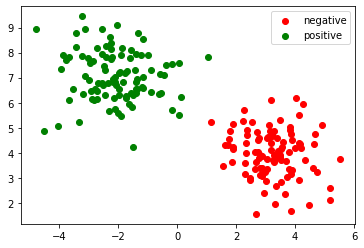

In [40]:
# plot X1 (separable)
nextplot()
plot2(X1, y1)

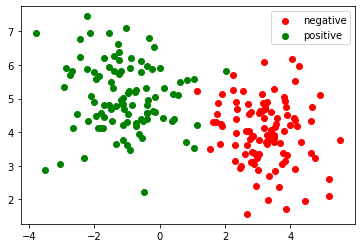

In [41]:
# plot X2 (not separable)
nextplot()
plot2(X2, y2)

In [42]:
def pt_classify(X, w):
    """Classify using a perceptron.

    Parameters
    ----------
    X : torch array of shape (N,D) or shape (D,)
        Design matrix of test examples
    w : torch array of shape (D,)
        Weight vector

    Returns
    -------
    torch array of shape (N,)
        Predicted binary labels (either 0 or 1)"""
    if X.dim() == 1:
        X = X.view(1, -1)
    return (X @ w >= 0).int()

## 1a+c Learning

In [43]:
def pt_train(X, y, maxepochs=100, pocket=False, w0=None):
    """Train a perceptron.

    Parameters
    ----------
    X : torch array of shape (N,D)
        Design matrix
    y : torch array of shape (N,)
        Binary labels (either 0 or 1)
    maxepochs : int
        Maximum number of passes through the training set before the algorithm
        returns
    pocket : bool
       Whether to use the pocket algorithm (True) or the perceptron learning algorithm
       (False)
    w0 : torch array of shape (D,)
        Initial weight vector

    Returns
    -------
    torch array of shape (D,)
        Fitted weight vector"""

    N, D = X.shape
    if w0 is None:  # initial weight vector
        w0 = torch.zeros(D)
    w = w0  # current weight vector
    
    train = X.clone()
    train_target = y.clone()
    train_target[train_target==0.0] = -1
    
    best_weight = w.clone()
    best_weight_count = 0
    
    if pocket: 
        for _ in range(maxepochs):
            for i in range(N):
                r = torch.randint(high=N, size=(1,1)).item()
                rand_sample = train[r]
                rand_sample_target = train_target[r]

                if  torch.sign(best_weight[1:]@rand_sample[1:])!= torch.sign(rand_sample_target):
                    best_weight_count = 0
                    best_weight[1:] += torch.sign(rand_sample_target) * rand_sample[1:] 
                elif torch.sign(best_weight[1:]@rand_sample[1:]) == torch.sign(rand_sample_target):
                    best_weight_count += 1
        best_weight[0] = 0.0
        w = best_weight.clone()
        print(f"the best weight vector classified {best_weight_count} samples correctly in a row")
        
    elif not pocket:
        no_updates: bool = False
        for _ in range(maxepochs):
            no_updates: bool = True
            for i, x in enumerate(train):
                if  torch.sign(w[1:]@x[1:])!= torch.sign(train_target[i]):
                    w[1:] += torch.sign(train_target[i]) * x[1:] 
                    no_updates = False
            if no_updates: 
                print(f"stopped training after {_} episodes")
                break
    
    return w
        
        

### 1a) When is it safe to stop percetron learning earlier? Why?

When the perceptron learning algorithm completes an entire training epoch (i.e. one pass through the entire training set) without any weight updates being applied. This is because all the signs are now "correct". That is, all examples are now correctly classified. This, obviously, only works in the separable case.

## 1b+d Experimentation

stopped training after 3 episodes


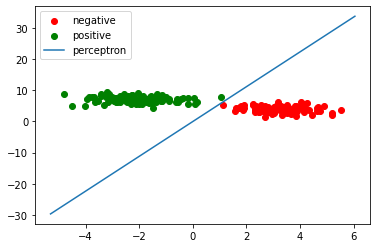

In [44]:
# Train a perceptron using the perceptron learning algorithm and plot decision
# boundary. You should get a perfect classification here. The decision boundary
# should not change if you run this multiple times.
w = pt_train(X1, y1)
nextplot()
plot2(X1, y1)
plot2db(w, label="perceptron")

the best weight vector classified 19912 samples correctly in a row


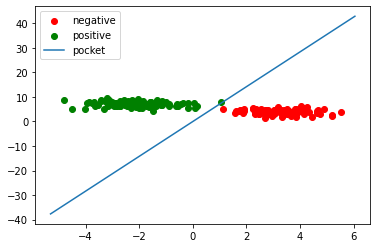

In [45]:
# Train a perceptron using the pocket algorithm and plot decision boundary. You
# should get a perfect classification here (with high probability). The decision
# boundary should change if you run this multiple times.
w = pt_train(X1, y1, pocket=True)
nextplot()
plot2(X1, y1)
plot2db(w, label="pocket")

D2 without the pocket algorithm

Misclassification rates (train)
Perceptron (best result): 4
Linear SVM (C=1)        : 3
Logistic regression     : 3


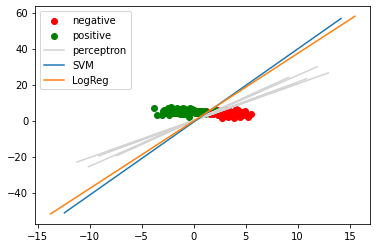

In [46]:
# Train 10 perceptrons starting with random weights. Also train logistic
# regression and SVM. Plot all decision boundaries, and print the
# misclassification rates (on training data). Try this with and without the
# pocket algorithm.
print("D2 without the pocket algorithm")
nextplot()
plot2dbs(X2, y2, n=10, maxepochs=1000, pocket=False)

D2 with the pocket algorithm
the best weight vector classified 133 samples correctly in a row
the best weight vector classified 174 samples correctly in a row
the best weight vector classified 23 samples correctly in a row
the best weight vector classified 7 samples correctly in a row
the best weight vector classified 162 samples correctly in a row
the best weight vector classified 50 samples correctly in a row
the best weight vector classified 3 samples correctly in a row
the best weight vector classified 33 samples correctly in a row
the best weight vector classified 138 samples correctly in a row
the best weight vector classified 279 samples correctly in a row

Misclassification rates (train)
Perceptron (best result): 1
Linear SVM (C=1)        : 3
Logistic regression     : 3


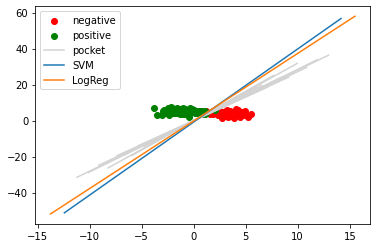

In [47]:
# Train 10 perceptrons starting with random weights. Also train logistic
# regression and SVM. Plot all decision boundaries, and print the
# misclassification rates (on training data). Try this with and without the
# pocket algorithm.
print("D2 with the pocket algorithm")
nextplot()
plot2dbs(X2, y2, n=10, maxepochs=1000, pocket=True)

## idk?

something to do with SVM being a maximum large margin classifier?

# 2 Multi-Layer Feed-Forward Neural Networks

## 2a Conjecture how an FNN fit will look like

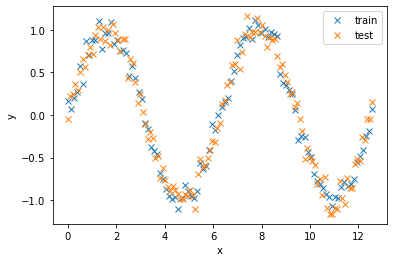

In [48]:
# here is the one-dimensional dataset that we will use
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plt.legend()

### Conjecture how a FNN fit will look like with 0, 1, 2 and 3 hidden neurons will look like

**0 hidden neurons:** y = mx + b where m is the weight from x to output
1. will look like a linear function. To minimise the loss, this function will take the form of a constant (i.e. mx will be 0) which is fully controlled by the "offset"/bias term

**1 hidden neuron:** y = w21 * sigmoid(w11,x + b) + b 
1. will look like a quadratic function (i.e. won't be able to fully reconstruct/fit the data). Due to the single sigmoid hidden unit, we will achieve some nonlinearity and therefore a better fit on the training data. This will still not be enough to fit dataset. The function will essentially will look like a shifted and/or scaled version of the sigmoid

**2 hidden neurons:** y = (w21 * sigmoid(w11,x + b11) + (w22 * sigmoid(w12,x + b12)) + b
1. Here, we have essentially two sigmoid functions which can be scaled/shifted as one pleases). Hence, the output will look like two interpolated sigmoids. This will still not be enough to fully fit the data. Essentially, the optimiser would adjust thr weights w21 and w22 such that the sigmoids at some point cancel out to achieve a "turn"

**3 hidden neurons:** y = (w21 * sigmoid(w11,x + b11) + (w22 * sigmoid(w12,x + b12)) + (w23 * sigmoid(w13,x + b13)) + b
1. will look like a x4 function and overfit or not be able to fully fit the data. Here, we're interpolating three sigmoids and should be able to achieve a near perfect fit on the training data

## 2b Train with 2 hidden units

In [49]:
# Training code. You do not need to modify this code.
train_bfgs = lambda model, **kwargs: train_scipy(X3, y3, model, **kwargs)


def train3(
    hidden_sizes, nreps=10, transfer=lambda: nn.Sigmoid(), train=train_bfgs, **kwargs
):
    """Train an FNN.

    hidden_sizes is a (possibly empty) list containing the sizes of the hidden layer(s).
    nreps refers to the number of repetitions.

    """
    best_model = None
    best_cost = math.inf
    for rep in range(nreps):
        model = fnn_model([1] + hidden_sizes + [1], transfer)
        print(f"Repetition {rep: 2d}: ", end="")
        model = train(model, **kwargs)
        mse = F.mse_loss(y3, model(X3)).item()
        if mse < best_cost:
            best_model = model
            best_cost = mse
        print(f"best_cost={best_cost:.3f}")

    return best_model

In [50]:
# Let's fit the model with one hidden layer consisting of 2 units.
model = train3([2], nreps=1)
print("Training error:", F.mse_loss(y3, model(X3)).item())
print("Test error    :", F.mse_loss(y3test, model(X3test)).item())

Repetition  0: Optimization terminated successfully.
         Current function value: 0.357250
         Iterations: 87
         Function evaluations: 107
         Gradient evaluations: 107
best_cost=0.357
Training error: 0.35724952816963196
Test error    : 0.3593898415565491


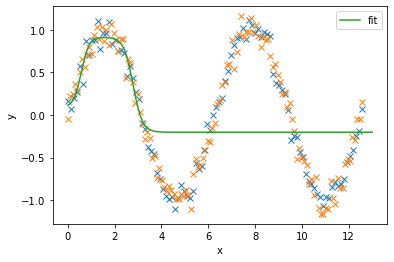

In [51]:
# plot the data and the fit
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)
# torch.linspace(0, 13, 500).unsqueeze(1): creates a tensor of dim 1 with 500 
# elements that are equally spaced from 0 to 13 (i.e. unsqueeze(1) is responsible)
# for the 1d part

In [52]:
# The weight matrices and bias vectors can be read out as follows. If you want,
# use these parameters to compute the output of the network (on X3) directly and
# compare to model(X3).
for par, value in model.state_dict().items():
    print(f"{par:<15}= {value}")

linear1.weight = tensor([[5.0166],
        [6.0143]])
linear1.bias   = tensor([-13.9790,  -3.4539])
output.weight  = tensor([[-1.1157,  0.8249]])
output.bias    = tensor([0.0880])


In [53]:
# now repeat this multiple times
# YOUR CODE HERE
model = train3([2], nreps=3)
print("Training error:", F.mse_loss(y3, model(X3)).item())
print("Test error    :", F.mse_loss(y3test, model(X3test)).item())

Repetition  0: Optimization terminated successfully.
         Current function value: 0.277769
         Iterations: 100
         Function evaluations: 114
         Gradient evaluations: 114
best_cost=0.278
Repetition  1: Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.079572
         Iterations: 392
         Function evaluations: 611
         Gradient evaluations: 600
best_cost=0.080
Repetition  2: Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.079572
         Iterations: 392
         Function evaluations: 568
         Gradient evaluations: 557
best_cost=0.080
Training error: 0.07957150042057037
Test error    : 0.08671527355909348


#### Is the result as you expected? Now repeat training multiple times. What happens? Explain.

The result is somewhat like I expected. As we essentially combine two sigmoid functions that learn different weights, we are not able to fully reconstruct/fit the training set. Also, depending on the initialisation we may get stuck in a local optimum. Hence, the changing results/fits when repeating training multiple times. 

In [54]:
# From now on, always train multiple times (nreps=10 by default) and
# report best model.
model = train3([2], nreps=10)
print("Training error:", F.mse_loss(y3, model(X3)).item())
print("Test error    :", F.mse_loss(y3test, model(X3test)).item())

Repetition  0: Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.079572
         Iterations: 416
         Function evaluations: 592
         Gradient evaluations: 582
best_cost=0.080
Repetition  1: Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.079572
         Iterations: 395
         Function evaluations: 550
         Gradient evaluations: 540
best_cost=0.080
Repetition  2: Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.079573
         Iterations: 351
         Function evaluations: 483
         Gradient evaluations: 472
best_cost=0.080
Repetition  3: Optimization terminated successfully.
         Current function value: 0.277769
         Iterations: 87
         Function evaluations: 97
         Gradient evaluations: 97
best_cost=0.080
Repetition  4: Optimization terminated successfully.
         Current function v

## 2c Width

In [55]:
# Experiment with different hidden layer sizes. To avoid recomputing
# models, you may want to save your models using torch.save(model, filename) and
# load them again using torch.load(filename).
#model1 = train3([1], nreps=10)
# model2 = train3([2], nreps=10)
# model3 = train3([3], nreps=10)
# model10 = train3([10], nreps=10)
# model50 = train3([50], nreps=10)
# model100 = train3([100], nreps=10)

### saving models

In [56]:
torch.save(model1, "model1.txt")
torch.save(model2, "model2.txt")
torch.save(model3, "model3.txt")
torch.save(model10, "model10.txt")
torch.save(model50, "model50.txt")
torch.save(model100, "model100.txt")

### loading models

In [57]:
model1 = torch.load("model1.txt")
model2 = torch.load("model2.txt")
model3 = torch.load("model3.txt")
model10 = torch.load("model10.txt")
model50 = torch.load("model50.txt")
model100 = torch.load("model100.txt")

### 1 hidden unit

Training error: 0.37291884422302246
Test error    : 0.37431666254997253


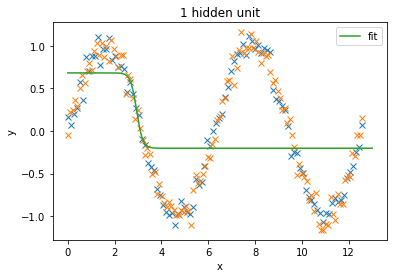

In [58]:
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model1)
plt.title("1 hidden unit")
print("Training error:", F.mse_loss(y3, model1(X3)).item())
print("Test error    :", F.mse_loss(y3test, model1(X3test)).item())

### 2 hidden units

Training error: 0.0795690268278122
Test error    : 0.08670894056558609


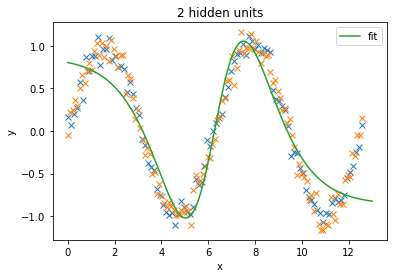

In [59]:
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model2)
plt.title("2 hidden units")
print("Training error:", F.mse_loss(y3, model2(X3)).item())
print("Test error    :", F.mse_loss(y3test, model2(X3test)).item())

### 3 hidden units

Training error: 0.00857526995241642
Test error    : 0.011264427565038204


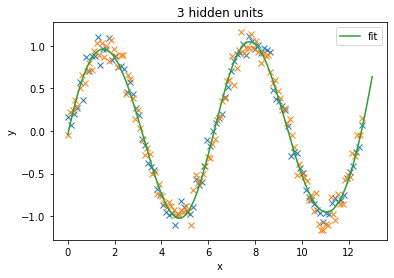

In [60]:
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model3)
plt.title("3 hidden units")
print("Training error:", F.mse_loss(y3, model3(X3)).item())
print("Test error    :", F.mse_loss(y3test, model3(X3test)).item())

### 10 hidden units

Training error: 0.005475340411067009
Test error    : 0.012296143919229507


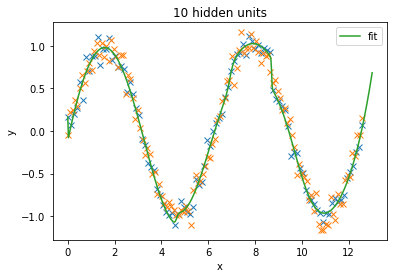

In [61]:
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model10)
plt.title("10 hidden units")
print("Training error:", F.mse_loss(y3, model10(X3)).item())
print("Test error    :", F.mse_loss(y3test, model10(X3test)).item())

### 50 hidden units

Training error: 0.0016042455099523067
Test error    : 3.343163013458252


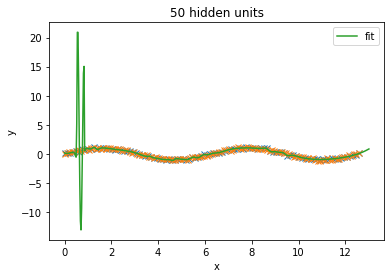

In [62]:
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model50)
plt.title("50 hidden units")
print("Training error:", F.mse_loss(y3, model50(X3)).item())
print("Test error    :", F.mse_loss(y3test, model50(X3test)).item())

### 100 hidden units

Training error: 0.0017645327607169747
Test error    : 688.1121215820312


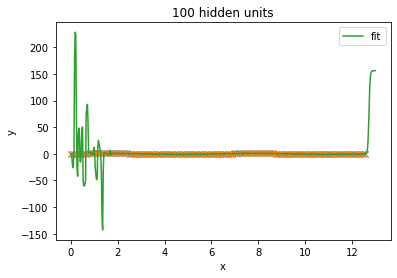

In [63]:
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model100)
plt.title("100 hidden units")
print("Training error:", F.mse_loss(y3, model100(X3)).item())
print("Test error    :", F.mse_loss(y3test, model100(X3test)).item())

### Then plot the dataset as well as the predictions of each FNN on the test set into a single plot.

In [64]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

TypeError: plot1() got an unexpected keyword argument 'axis'

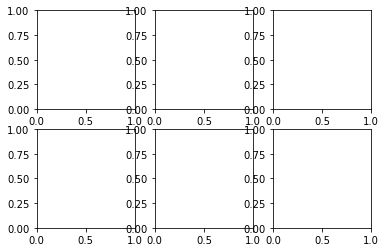

In [65]:
nextplot()
axs = plt.gcf().subplots(2, 3)

plot1(X3, y3, label="train", axis=axs[0][0])
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model100)
plt.title("100 hidden units")
axs[0][0].set_title('100 hidden units')

plot_xy(lon, lat, Z_clusters[0], axis=axs[0][1])
axs[0][1].set_title('PCA k=1')

plot_xy(lon, lat, Z_clusters[1], axis=axs[1][0])
axs[1][0].set_title('PCA k=2')


plot_xy(lon, lat, Z_clusters[2], axis=axs[1][1])
axs[1][1].set_title('PCA k=3')

plt.show()

### What happens when the number of hidden neurons increases? Is this what you expected? Discuss!

Yup, I expected overfitting to happen at some point

## 2d Distributed representations

### 1 hidden unit

In [ ]:
# train a model to analyze
model_dist_2 = train3([2])
torch.save(model_dist_1, "models/model_dist_2.txt")
model_dist_2 = torch.load("models/model_dist_2.txt")

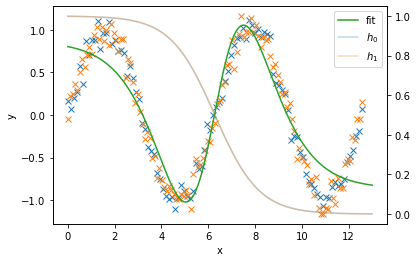

In [115]:
# plot the fit as well as the outputs of each neuron in the hidden
# layer (scale for the latter is shown on right y-axis)
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model_dist_2, hidden=True, scale=False)

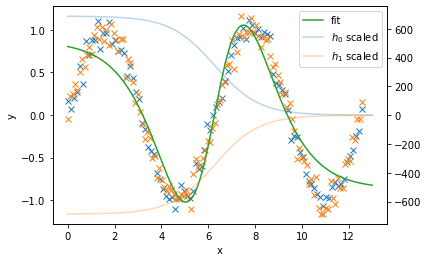

In [116]:
# plot the fit as well as the outputs of each neuron in the hidden layer, scaled
# by its weight for the output neuron (scale for the latter is shown on right
# y-axis)
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model_dist_2, hidden=True, scale=True)

### 3 hidden units

In [127]:
# model_dist_3 = train3([3])
# torch.save(model_dist_3, "models/model_dist_3.txt")
model_dist_3 = torch.load("models/model_dist_3.txt")

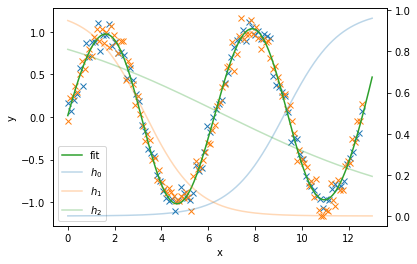

In [129]:
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model_dist_3, hidden=True, scale=False)

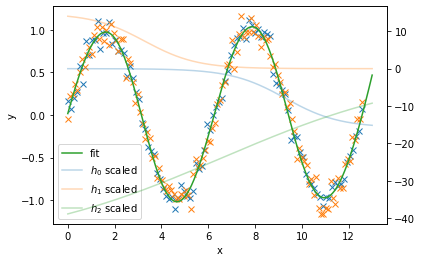

In [126]:
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model_dist_3, hidden=True, scale=True)

### 10 hidden units

In [118]:
# model_dist_10 = train3([10])
# torch.save(model_dist_10, "models/model_dist_10.txt")
model_dist_10 = torch.load("models/model_dist_10.txt")

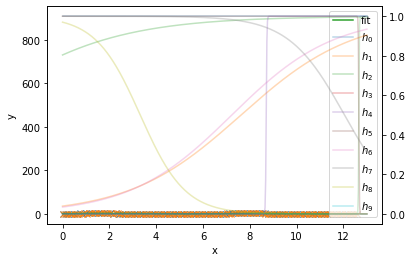

In [119]:
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model_dist_10, hidden=True, scale=False)

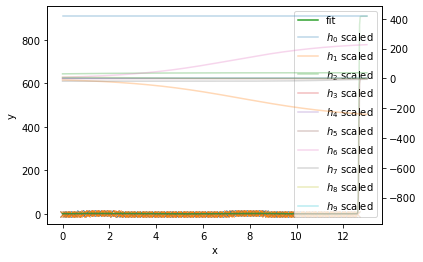

In [120]:
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model_dist_10, hidden=True, scale=True)

### Try to explain how the FNN obtains its flexibility. Is the distributed representation intuitive?

For 1 and 3 hidden units the distributed representation is intuitive. The different units learn parts of the target function and are then combined/scaled/shifted with the output weights/biases to fit the datasets. Same applies for the FNN with 10 hidden units, though here it is not as easy to "read off" how the hidden units combine to fit the dataset

## 2e Experiment with different optimizers (optional)

In [ ]:
# PyTorch provides many gradient-based optimizers; see
# https://pytorch.org/docs/stable/optim.html. You can use a PyTorch optimizer
# as follows.
train_adam = lambda model, **kwargs: fnn_train(
    X3, y3, model, optimizer=torch.optim.Adam(model.parameters(), lr=0.01), **kwargs
)
model = train3([5, 1], nreps=10, train=train_adam, max_epochs=5000, tol=1e-8, verbose=False)
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)

In [ ]:
# Experiment with different number of layers and activation functions. Here is
# an example with three hidden layers (of sizes 4, 5, and 6) and ReLU activations.
#
# You can also plot the outputs of the hidden neurons in the first layer (using
# the same code above).
model = train3([60, 2], nreps=50, transfer=lambda: nn.ReLU())
nextplot()
plot1(X3, y3, label="train")
plot1(X3test, y3test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)
print("Training error:", F.mse_loss(y3, model(X3)).item())
print("Test error    :", F.mse_loss(y3test, model(X3test)).item())